# KNN and Cross-validation

**ELEC-E8739 - AI in health technologies**

(c) Prof. Aleksei Tiulpin, PhD

In this tutorial, we will play with `scikit-learn`, the go-to ML library. We will be using the famous Wisconsin Breast Cancer Dataset. These data comprise various morphological features found in pathology samples taken after breast cancer surgery. The goal of a pathologist here is to find whether the tumor was malignant or not. If it was, then the patient goes to chemotherapy. Here is how the source data looks like ([Wikicommons](https://commons.wikimedia.org/wiki/File:Breast_invasive_scirrhous_carcinoma_histopathology_(1).jpg)):

<img src="https://upload.wikimedia.org/wikipedia/commons/7/71/Breast_invasive_scirrhous_carcinoma_histopathology_%281%29.jpg" alt="Drawing" style="width: 500px;margin-left:auto; margin-right:auto"/>

You can find more details about the data on [UCI](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) and the original paper: 

```
K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34
```


## Imports

In [63]:
# Data / tensors and whatnot
import numpy as np
# Plotting
import matplotlib.pyplot as plt
# ML stuff
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef
from sklearn.datasets import load_breast_cancer

## Loading the data

Scikit learn will download teh Wisconsin data from the internet for you.

In [32]:
X, y = load_breast_cancer(return_X_y=True)

## Cross-validation

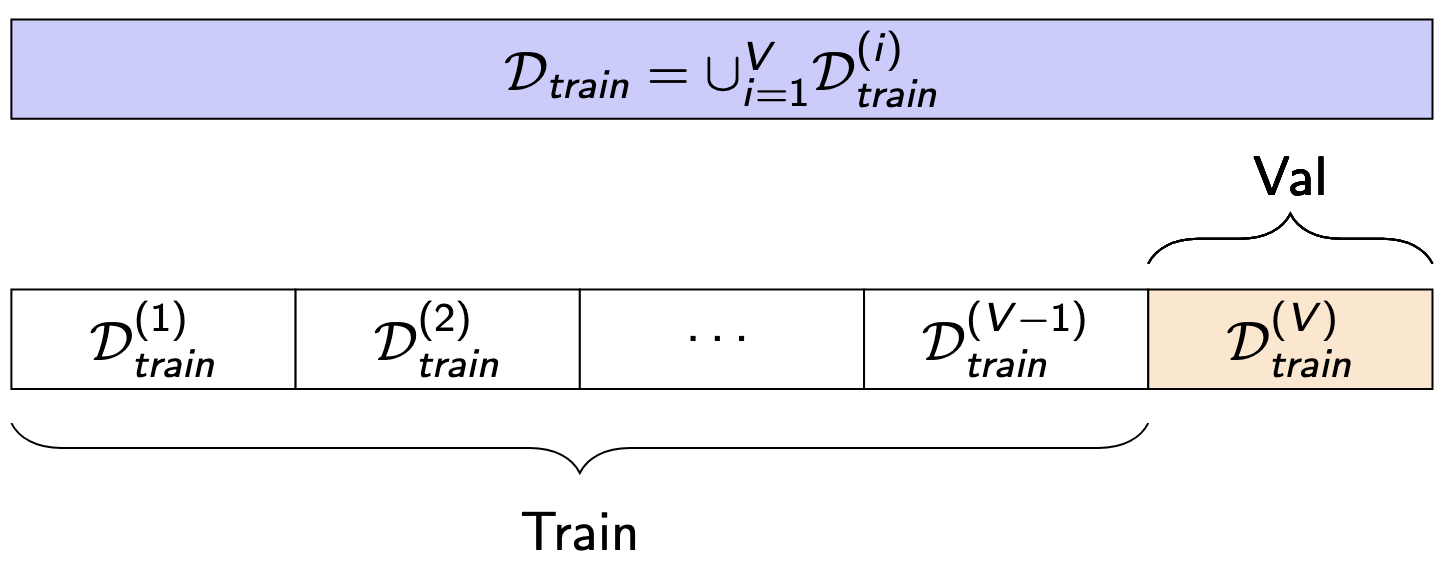

We can split the data ourselves before starting to use any library. 

How to do it for the train/test split:

1. Shuffle a set of indices $1, \dots, N$ and put it to an array `ind`.
2. Sample the train and test data using the ind based on the pre-defined size of train data

In Python, we would just need to call `X[ind[:train_size]]` and `X[ind[train_size:]]`. By analogy, we can implement similar in the code. Let's do it!

In [57]:
n_folds = 5 # 5 folds
ind = np.random.choice(X.shape[0], X.shape[0], replace=False)
chunk_size = int(np.ceil(X.shape[0] / n_folds))

# Sorry, I just like one-liners!
# We will first create a list of folds (numpy arrays of indices)
folds = [ind[start:start + chunk_size] for start in range(0, X.shape[0], chunk_size)]

To make cross-validation work, write a loop through testing folds as follows

In [ ]:
for fold in range(len(folds)):
    test_idx = folds[fold]
    # Below we use all folds except one that we are at
    train_idx = np.hstack([folds[idx] for idx in filter(lambda x: x != fold, range(len(folds)))])

    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]

    ############################################################
    # Machine learning stuff: data pre-processing, modelling etc
    ############################################################

Stop! But the code above does not really do any machine learning. We indeed to add it!

We now can use the kNN classifier that we have imported from `scikit-learn`.

In [43]:
# We store the cross-validation scores here
cv_scores = []
# Let's repeat the code we already wrote and add the ML stuff
for fold in range(len(folds)):
    test_idx = folds[fold]
    # Below we use all folds except one that we are at
    train_idx = np.hstack([folds[idx] for idx in filter(lambda x: x != fold, range(len(folds)))])

    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]

    ############################################################
    # Machine learning stuff: data pre-processing, modelling etc
    ############################################################

    # Let's initialize the object
    clf = KNeighborsClassifier(n_neighbors=3)
    # Fit the data
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    # Evaluate
    acc = balanced_accuracy_score(y_te, y_pred)
    # Store the score value
    cv_scores.append(acc)

In [44]:
score = np.mean(cv_scores)
std = np.std(cv_scores)
print(f"CV score: {score:.2f}±{std:.2f}")

CV score: 0.91±0.01


Pretty good accuract, innit?

## Cross-validation with Scikit-Learn

In `scikit-learn`, cross validation-related API can be found in the `sklearn.model_selection` module. Let us start from the K-fold (we call it V-fold in the lecture).

In [55]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = []
for train_idx, test_idx in cv.split(X, y):
    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]
    # Fit
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_tr, y_tr)
    # Predict 
    y_pred = clf.predict(X_te)
    # Evaluate
    acc = balanced_accuracy_score(y_te, y_pred)
    # Store the score value
    cv_scores.append(acc)

In [56]:
score = np.mean(cv_scores)
std = np.std(cv_scores)
print(f"CV score: {score:.2f}±{std:.2f}")

CV score: 0.91±0.03


The results are quite similar in terms of mean, but due to randomness and slight difference in implementation, the variances differ. I recommend to always use `scikit-learn` implementation. 

## Stratified splitting

The basic KFold/VFold is not good enough. It ignores class imbalance. Luckily, there is a drop-in replacement for it, called stratified K-Fold. The idea of this approach is to make sure that the distribution of labels between train and validation is the same.

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
for train_idx, test_idx in cv.split(X, y):
    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]
    # Fit
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_tr, y_tr)
    # Predict 
    y_pred = clf.predict(X_te)
    # Evaluate
    acc = balanced_accuracy_score(y_te, y_pred)
    # Store the score value
    cv_scores.append(acc)

In [61]:
score = np.mean(cv_scores)
std = np.std(cv_scores)
print(f"CV score: {score:.2f}±{std:.2f}")

CV score: 0.92±0.03


The stratified CV score is much more objective, hence I recommend you to use this method!

## Looking at the hyperparameters of the KNN

In applications, we want to evaluate hyperparameters with CV. What kind of things could we evaluate? Well, in knn:

* Number of neigbors
* Preprocessing

Why do we need preprocessing, is to make sure that features with high variance do not affect the distance very significantly. Here, we will use the mean-std scaling to make sure that all features are evenly balanced.

In a very basic scenario, you can just loop over hyperparameters. 

In [65]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
# Here we store the grid of hyperparameters in a dict 
k_perf = {}
neigbors = np.array([1, 3, 5, 7, 9, 11, 15, 17, 21, 23, 25], dtype=int)

In [66]:
for scale in [True, False]: # with and without scaling
    k_perf[scale] = {}
    # Let's see how we can evaluate different metrics.
    for metric in ["acc", "f1", "mcc"]:
        k_perf[scale][metric] = []
    for n_neighbors in neigbors:
        # This is our CV split
        # We have already gone through "scale" and now evaluating for one scaling setting all numbers of NN 
        for train_idx, test_idx in cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            # Here we use the state variable that we loop over in teh very beginning
            if scale:
                # Mean-std scaling
                mean = X_train.mean(axis=0)
                std = X_train.std(axis=0)
                X_train = (X_train - mean) / std
                X_test = (X_test - mean) / std
            # Finally the KNN
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            # Let's store the metrics
            k_perf[scale]["acc"].append(balanced_accuracy_score(y_test, y_pred))
            k_perf[scale]["f1"].append(f1_score(y_test, y_pred))
            k_perf[scale]["mcc"].append(matthews_corrcoef(y_test, y_pred))
    # D not forget to agregate the metrics properly. Here, for every hyperparameter setting, 
    # we will store the scores from all 5 folds
    k_perf[scale]["acc"] = np.array(k_perf[scale]["acc"]).reshape(-1, cv.get_n_splits())
    k_perf[scale]["f1"] = np.array(k_perf[scale]["f1"]).reshape(-1, cv.get_n_splits())
    k_perf[scale]["mcc"] = np.array(k_perf[scale]["mcc"]).reshape(-1, cv.get_n_splits())

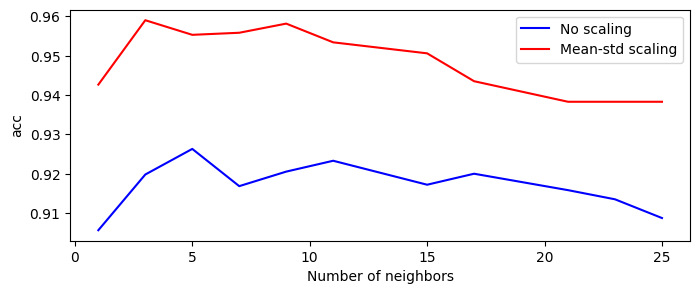

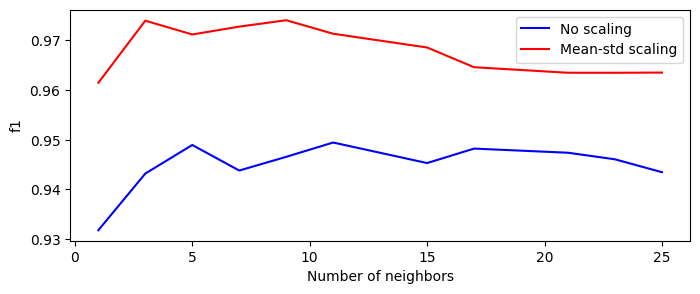

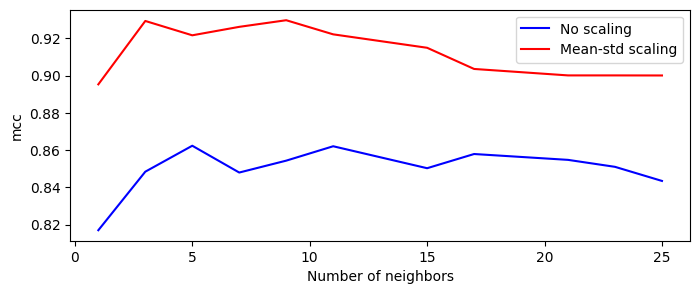

In [71]:
for metric in ["acc", "f1", "mcc"]:
    plt.figure(figsize=(8, 3), dpi=100)
    ax = plt.subplot(111)
    # Showing both hyperparameter settings
    ax.plot(neigbors,  k_perf[False][metric].mean(axis=1), 'b', label='No scaling')
    ax.plot(neigbors,  k_perf[True][metric].mean(axis=1), 'r', label='Mean-std scaling')
    # Some plot-related mambo-jambo
    ax.set_xlabel('Number of neighbors')
    ax.set_ylabel(metric)
    ax.legend()
    plt.show()